<a href="https://colab.research.google.com/github/YoussefKhafaga/Facial-Recognition/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mohamed Raslan:6535
Youssef Khafaga:6326
Mohamed Sherif:6166

# FACE Recognition using PCA and LDA
Our Database of Faces, (formerly 'The ORL Database of Faces'), contains a set of face images taken between April 1992 and April 1994 at the lab. The database was used in the context of a face recognition project carried out in collaboration with the Speech, Vision and Robotics Group of the Cambridge University Engineering Department.

There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). A preview image of the Database of Faces is available.

#**1-Read the data set and generate the data matrix**

Imports

In [ ]:
import zipfile
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  
import pandas as pd
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


faces + non faces data


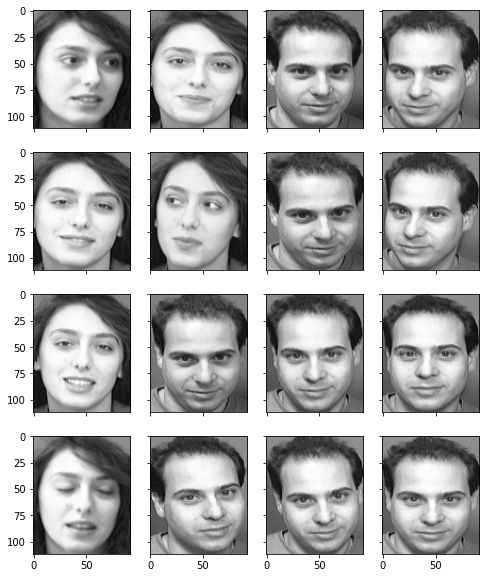

In [ ]:
faces=[]
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive.zip", 'r')
for x in zip_ref.namelist():
  if not x.endswith(".pgm"):
    continue
  with zip_ref.open(x) as image:
    temp = x.split('/')
    faces.append(cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE))
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces)[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")

In [ ]:
data=[]
for i in faces:
  data.append(i.flatten())
data = np.array(data)
df1 = pd.DataFrame(data)
pointer = 0
ids = []
for i in range(0, 400):
  if i % 10 == 0:
    pointer +=1
  ids.append(pointer) 
df1.insert(0,'id',ids)
X_train=df1.iloc[1::2].iloc[:,1:].values
y_train=df1.iloc[1::2].iloc[:,0].values
X_test=df1.iloc[::2].iloc[:,1:].values
y_test=df1.iloc[::2].iloc[:,0].values

reads PGM file and convert it to a np array then adds the ids to it and generate the data frame 
**flatten : Return a copy of the array collapsed into one dimension.



#**2-PCA**


Using PCA to reduce dimensions according to the alphas given (0.8, 0.85, 0.9, 0.95)

In [ ]:
def PCA(X_train, y_train, X_test, y_test):
  alphas = [0.8,0.85,0.9,0.95]
  mean_mat=np.mean(X_train, axis=0)
  data_centred_mat=X_train-np.transpose(mean_mat)
  covariance=np.cov(data_centred_mat, rowvar=False, bias=True)
  eigvalues, eigvectors=np.linalg.eigh(covariance)
  R_dims=[]
  indices=[]
  eigvalues=sorted(eigvalues, reverse=True)
  for i in range(len(eigvalues)):
    R_dims.append(sum(eigvalues[0:i])/sum(eigvalues))
  for alpha in alphas:
    for R_dim in R_dims:
      if R_dim>=alpha:
        indices.append(R_dims.index(R_dim))
        break
  eigimp=[]
  eigvectors=eigvectors.T[::-1]
  for index in indices:
    eigimp.append(eigvectors[:, :index])
  projected_train=[]
  projected_test=[]
  for i in range(len(eigimp)):
    projected_train.append(np.dot(X_train, eigimp[i]))
    projected_test.append(np.dot(X_test, eigimp[i]))
  classify_PCA(projected_train, projected_test, y_train, y_test)

KNN was then used for classification and in case of a tie, it was broken by KNeighborsClassifier.predict calling scipy.stats.mode, whose documentation says:
Returns an array of the modal (most common) value in the passed array.
If there is more than one such value, only the first is returned.
So, in the case of ties, the answer will be the class that happens to appear first in the set of neighbors. We then plot 4 scatter graphs (1 for each value of alpha) of values of K (number of neighbors in KNN) on the x-axis against their respective accuracies on the y-axis

In [ ]:
def classify_PCA(projected_train, projected_test, y_train, y_test):
  alphas = [0.8,0.85,0.9,0.95]
  k=[1,3,5,7]
  for i in range(len(projected_train)):
    accuracies=[]
    print("For alpha =",alphas[i])
    for value in k:
      knn=KNeighborsClassifier(n_neighbors=value)
      knn.fit(projected_train[i], y_train)
      y_pred = knn.predict(projected_test[i])
      accuracies.append(accuracy_score(y_test, y_pred))
      print("Accuracy for k =",value,":", accuracies[-1])
    plt.scatter(k,accuracies)
    plt.xlabel("K")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.show()

Test size 50%

Maximum accuracy was 86% at k=1 and alpha=0.95. The general trend is that when alpha increases, the accuracy increases and when K increases, the accuracy decreases.

For alpha = 0.8
Accuracy for k = 1 : 0.69
Accuracy for k = 3 : 0.63
Accuracy for k = 5 : 0.58
Accuracy for k = 7 : 0.575


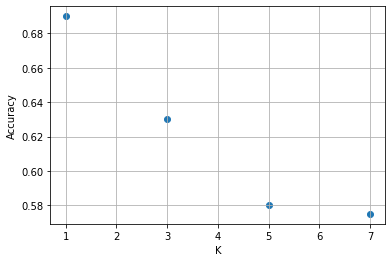

For alpha = 0.85
Accuracy for k = 1 : 0.795
Accuracy for k = 3 : 0.71
Accuracy for k = 5 : 0.705
Accuracy for k = 7 : 0.68


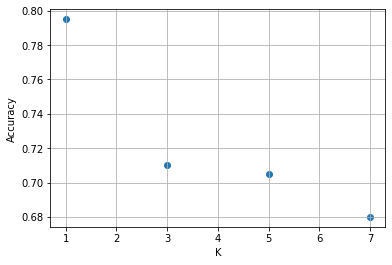

For alpha = 0.9
Accuracy for k = 1 : 0.835
Accuracy for k = 3 : 0.735
Accuracy for k = 5 : 0.74
Accuracy for k = 7 : 0.705


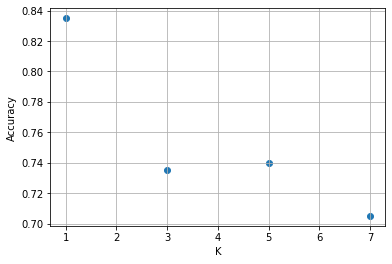

For alpha = 0.95
Accuracy for k = 1 : 0.86
Accuracy for k = 3 : 0.815
Accuracy for k = 5 : 0.79
Accuracy for k = 7 : 0.755


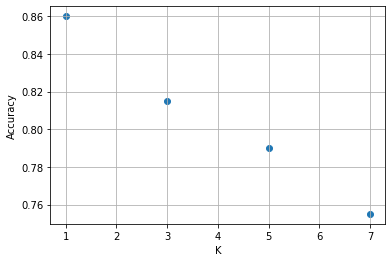

In [ ]:
PCA(X_train, y_train, X_test, y_test)

Test size 30%

For alpha = 0.8
Accuracy for k = 1 : 0.75
Accuracy for k = 3 : 0.575
Accuracy for k = 5 : 0.5916666666666667
Accuracy for k = 7 : 0.5416666666666666


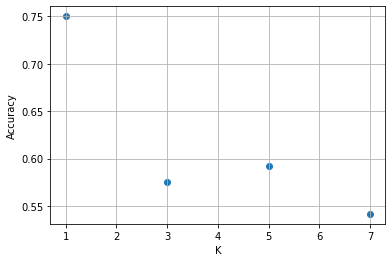

For alpha = 0.85
Accuracy for k = 1 : 0.8416666666666667
Accuracy for k = 3 : 0.7416666666666667
Accuracy for k = 5 : 0.7
Accuracy for k = 7 : 0.6333333333333333


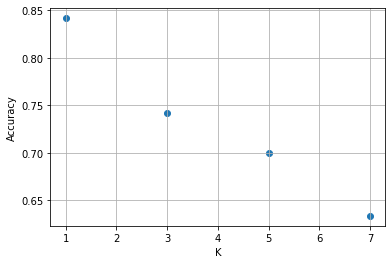

For alpha = 0.9
Accuracy for k = 1 : 0.9083333333333333
Accuracy for k = 3 : 0.7916666666666666
Accuracy for k = 5 : 0.6916666666666667
Accuracy for k = 7 : 0.6916666666666667


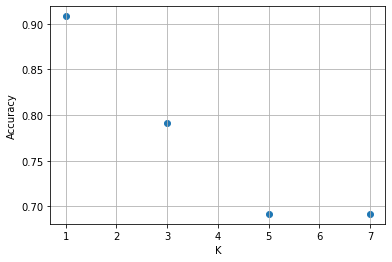

For alpha = 0.95
Accuracy for k = 1 : 0.925
Accuracy for k = 3 : 0.825
Accuracy for k = 5 : 0.7583333333333333
Accuracy for k = 7 : 0.7333333333333333


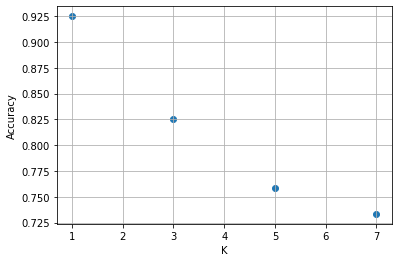

In [ ]:
X = df1.iloc[:, 1:10305].values
y = df1['id'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.3, random_state=0)
PCA(X_train, y_train, X_test, y_test)

#**3-LDA**

LDA was used to reduce dimensions of our data according to the labels that we alrady have (ID of each person ranging from 1 to 40).

In [ ]:
def LDA(X_train, y_train, X_test, y_test ,no_classes):
  mean_overall = np.mean(X_train, axis = 0)
  classes_mean = np.zeros((no_classes, 10304))
  SW = np.zeros((10304, 10304))
  SB = np.zeros((10304, 10304))
  class_labels = np.unique(y_train)
  for c in class_labels:
    X_c = X[y == c]
    classes_mean = np.mean(X_c, axis=0)
    SB = np.add(SB, np.dot(5, np.dot((classes_mean-mean_overall), (classes_mean-mean_overall).T)))
    SW = np.add(SW, np.dot((X_c - classes_mean).T, (X_c - classes_mean)))
  A = np.linalg.inv(SW).dot(SB)
  eigenvalues, eigenvectors = np.linalg.eigh(A)
  dominant_eigenvectors = eigenvectors[:,:39]
  projected_train_set = (np.dot(X_train, dominant_eigenvectors))
  projected_test_set = (np.matmul(X_test, dominant_eigenvectors))
  classify(projected_train_set, projected_test_set, y_train, y_test)

Same as PCA KNN was used for classification with the same tie breaking rule, but we plot only 1 graph here with values of K on x-axis and accuracies on y-axis.

In [ ]:
def classify(projected_train_set, projected_test_set, y_train, y_test):
  k=[1,3,5,7]
  accuracies = []
  for value in k:
    knn=KNeighborsClassifier(n_neighbors=value)
    knn.fit(projected_train_set, y_train)
    y_pred = knn.predict(projected_test_set)
    accuracies.append(accuracy_score(y_test, y_pred))
    print("Accuracy for k =",value,":", accuracy_score(y_test, y_pred))
  plt.scatter(k,accuracies)
  plt.xlabel("K")
  plt.ylabel("Accuracy")
  plt.grid()
  plt.show()

test size 50%

[-6.65513819e+22 -2.19930553e+22 -1.38649603e+22 ...  1.39047971e+22
  2.20389709e+22  6.69828552e+22]
Accuracy for k = 1 : 0.9333333333333333
Accuracy for k = 3 : 0.875
Accuracy for k = 5 : 0.7583333333333333
Accuracy for k = 7 : 0.7083333333333334


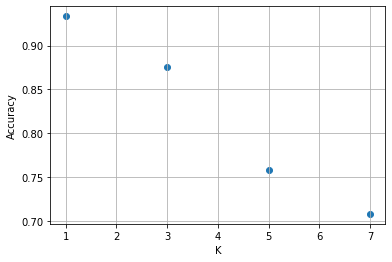

In [ ]:
LDA(X_train, y_train, X_test, y_test, 40)

test size 30%

[-6.65513819e+22 -2.19930553e+22 -1.38649603e+22 ...  1.39047971e+22
  2.20389709e+22  6.69828552e+22]
Accuracy for k = 1 : 0.9333333333333333
Accuracy for k = 3 : 0.875
Accuracy for k = 5 : 0.7583333333333333
Accuracy for k = 7 : 0.7083333333333334


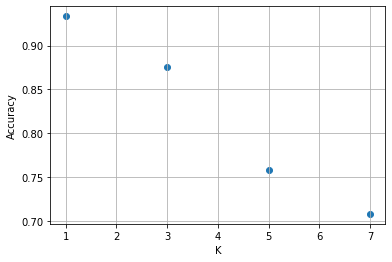

In [ ]:
X = df1.iloc[:, 1:10305].values
y = df1['id'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.3, random_state=0)
LDA(X_train, y_train, X_test, y_test, 40)

# **4- Compare vs Non-Face Images**

Reading another dataset of non-face images

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/cheetah.zip", 'r')
cheetah=[]
for x in zip_ref.namelist():
  if not x.endswith(".jpg"):
    continue
  with zip_ref.open(x) as image:
    img = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (92,112))
    cheetah.append(img.flatten())

Accuaracy for 200, 400, 600, 900 non faces. Using the PCA and LDA used above and KNN classification, we added another dataset of non-face images and classified the faces as 0 and the non-face images as 1.

200 non-faces and 400 faces
LDA
[-4.16728017e+20 -1.30607481e+20 -7.66767032e+19 ...  7.69276396e+19
  1.30504713e+20  4.16402907e+20]
Accuracy for k = 1 : 0.9466666666666667
Accuracy for k = 3 : 0.93
Accuracy for k = 5 : 0.9233333333333333
Accuracy for k = 7 : 0.92


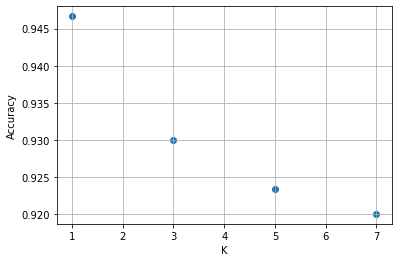

PCA
For alpha = 0.8
Accuracy for k = 1 : 0.88
Accuracy for k = 3 : 0.8766666666666667
Accuracy for k = 5 : 0.86
Accuracy for k = 7 : 0.8533333333333334


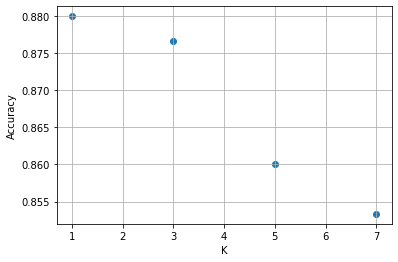

For alpha = 0.85
Accuracy for k = 1 : 0.9066666666666666
Accuracy for k = 3 : 0.8733333333333333
Accuracy for k = 5 : 0.87
Accuracy for k = 7 : 0.8633333333333333


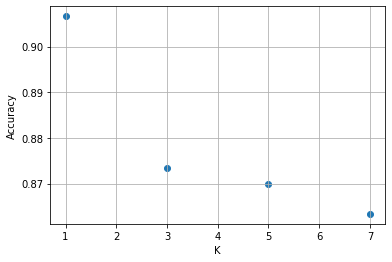

For alpha = 0.9
Accuracy for k = 1 : 0.91
Accuracy for k = 3 : 0.88
Accuracy for k = 5 : 0.86
Accuracy for k = 7 : 0.8566666666666667


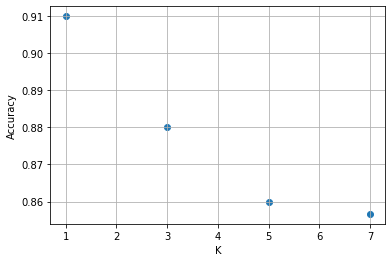

For alpha = 0.95
Accuracy for k = 1 : 0.94
Accuracy for k = 3 : 0.8866666666666667
Accuracy for k = 5 : 0.8533333333333334
Accuracy for k = 7 : 0.8533333333333334


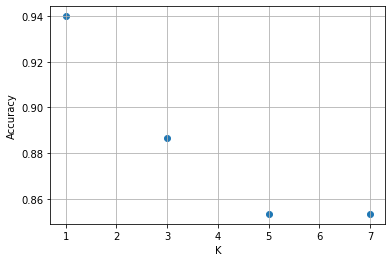

400 non-faces and 400 faces
LDA
[-3.53320920e+19 -1.12990816e+19 -6.75247398e+18 ...  6.75308893e+18
  1.12091333e+19  3.53828877e+19]
Accuracy for k = 1 : 0.9525
Accuracy for k = 3 : 0.9525
Accuracy for k = 5 : 0.9425
Accuracy for k = 7 : 0.9325


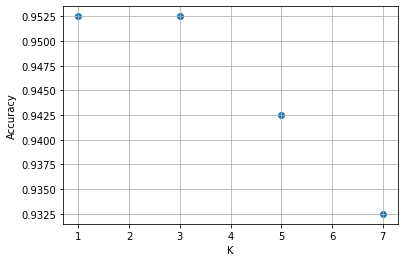

PCA
For alpha = 0.8
Accuracy for k = 1 : 0.92
Accuracy for k = 3 : 0.8925
Accuracy for k = 5 : 0.8825
Accuracy for k = 7 : 0.89


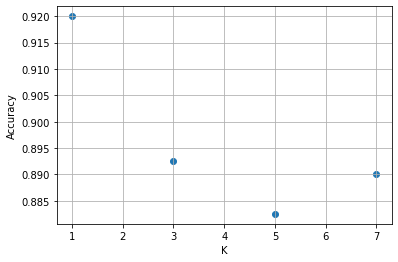

For alpha = 0.85
Accuracy for k = 1 : 0.9275
Accuracy for k = 3 : 0.9125
Accuracy for k = 5 : 0.905
Accuracy for k = 7 : 0.91


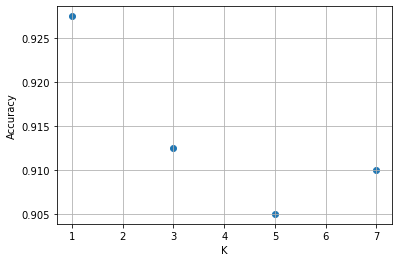

For alpha = 0.9
Accuracy for k = 1 : 0.9425
Accuracy for k = 3 : 0.9275
Accuracy for k = 5 : 0.915
Accuracy for k = 7 : 0.9075


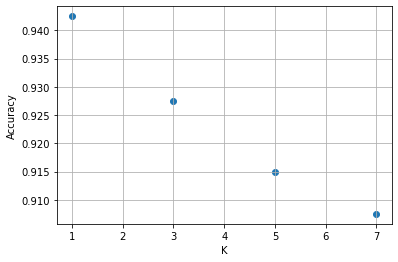

For alpha = 0.95
Accuracy for k = 1 : 0.9525
Accuracy for k = 3 : 0.945
Accuracy for k = 5 : 0.93
Accuracy for k = 7 : 0.9225


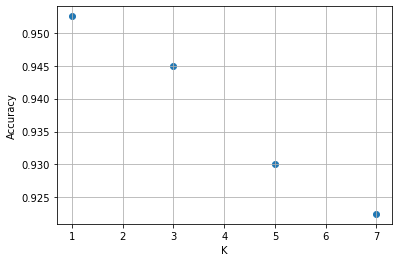

600 non-faces and 400 faces
LDA
[-9.27415486e+19 -2.94616748e+19 -1.69928840e+19 ...  1.70775415e+19
  2.93945446e+19  9.27460918e+19]
Accuracy for k = 1 : 0.95
Accuracy for k = 3 : 0.958
Accuracy for k = 5 : 0.95
Accuracy for k = 7 : 0.942


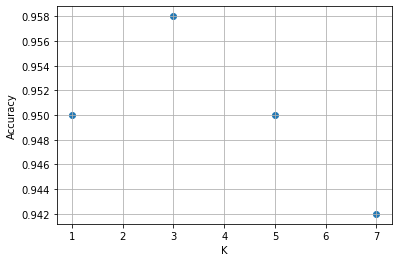

PCA
For alpha = 0.8
Accuracy for k = 1 : 0.954
Accuracy for k = 3 : 0.95
Accuracy for k = 5 : 0.952
Accuracy for k = 7 : 0.948


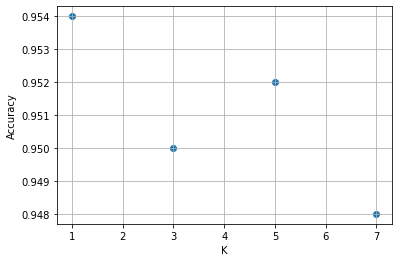

For alpha = 0.85
Accuracy for k = 1 : 0.94
Accuracy for k = 3 : 0.938
Accuracy for k = 5 : 0.948
Accuracy for k = 7 : 0.942


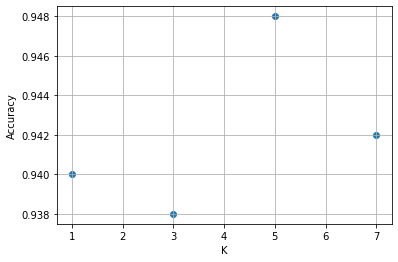

For alpha = 0.9
Accuracy for k = 1 : 0.948
Accuracy for k = 3 : 0.942
Accuracy for k = 5 : 0.942
Accuracy for k = 7 : 0.946


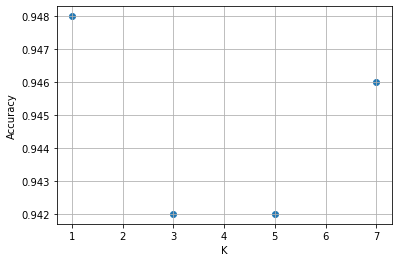

For alpha = 0.95
Accuracy for k = 1 : 0.95
Accuracy for k = 3 : 0.944
Accuracy for k = 5 : 0.948
Accuracy for k = 7 : 0.954


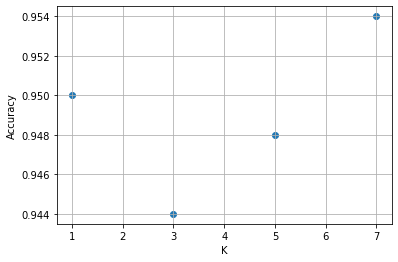

900 non-faces and 400 faces
LDA
[-2.91019430e+19 -9.25804967e+18 -5.44704616e+18 ...  5.47559449e+18
  9.27231250e+18  2.91141227e+19]
Accuracy for k = 1 : 0.9615384615384616
Accuracy for k = 3 : 0.9723076923076923
Accuracy for k = 5 : 0.9646153846153847
Accuracy for k = 7 : 0.9646153846153847


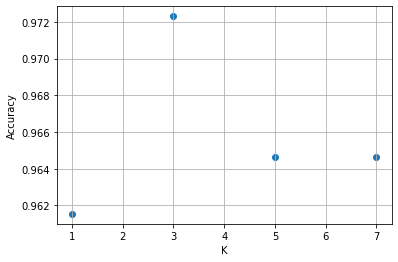

PCA
For alpha = 0.8
Accuracy for k = 1 : 0.963076923076923
Accuracy for k = 3 : 0.9384615384615385
Accuracy for k = 5 : 0.9523076923076923
Accuracy for k = 7 : 0.9461538461538461


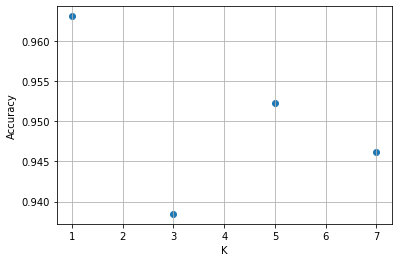

For alpha = 0.85
Accuracy for k = 1 : 0.96
Accuracy for k = 3 : 0.9538461538461539
Accuracy for k = 5 : 0.9523076923076923
Accuracy for k = 7 : 0.9553846153846154


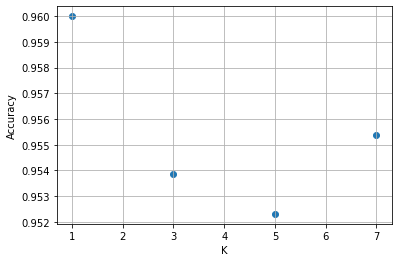

For alpha = 0.9
Accuracy for k = 1 : 0.9676923076923077
Accuracy for k = 3 : 0.9676923076923077
Accuracy for k = 5 : 0.963076923076923
Accuracy for k = 7 : 0.9615384615384616


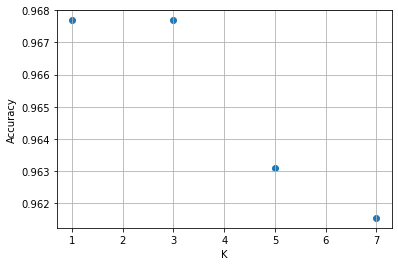

For alpha = 0.95
Accuracy for k = 1 : 0.98
Accuracy for k = 3 : 0.9646153846153847
Accuracy for k = 5 : 0.9661538461538461
Accuracy for k = 7 : 0.9676923076923077


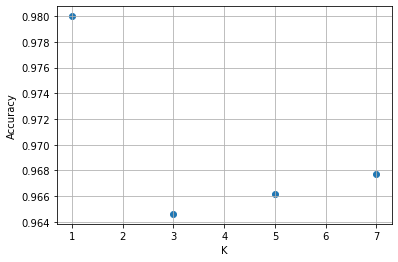

In [ ]:
cheetah = np.array(cheetah)
non_faces = [200, 400, 600, 900]
for i in non_faces:
  label = []
  cheetah1 = cheetah[0 : i, :]
  d = np.append(data,cheetah1,axis=0)
  dataf = pd.DataFrame(d)
  for x in range(0,400):
    label.append(1)
  for j in range(0,i):
    label.append(0)

  dataf.insert(0,"label",label)
  X = dataf.iloc[:, 1:10305].values
  y = dataf["label"].values
  X_train=dataf.iloc[1::2].iloc[:,1:].values
  y_train=dataf.iloc[1::2].iloc[:,0].values
  X_test=dataf.iloc[::2].iloc[:,1:].values
  y_test=dataf.iloc[::2].iloc[:,0].values
  print(i , "non-faces" , "and 400 faces")
  print("LDA")
  LDA(X_train, y_train, X_test, y_test, 2)
  print("PCA")
  PCA(X_train, y_train, X_test, y_test)

As we increased the size of the non-face dataset, the accuracy increased for both LDA and PCA as shown by the graphs above. The accuracy resemble success cases and 1-accuracy resembles failure cases.